<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/master/imdb_lstm_AAAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install gpytorch
!pip install tensorflow-determinism

In [ ]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!cp -r "drive/My Drive/NIPS2020/auxfunc/" .
!cp -r "drive/My Drive/NIPS2020/datasets/" .
!cp -r "drive/My Drive/NIPS2020/style/" .
!cp -r "drive/My Drive/NIPS2020/runs/" .

In [ ]:
%load_ext tensorboard

In [12]:
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, \
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])
import os
import random

In [13]:
#%%
# Define LSTM architecture
def LSTM_model(top_words, emb_vector_length, max_review_length, objective, reg=0.01):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(top_words,emb_vector_length,input_length=max_review_length))
    model.add(tf.keras.layers.LSTM(100))
    if objective == 'svm':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='linear', kernel_regularizer=tf.keras.regularizers.l2(reg)
        ))
    elif objective == 'softmax':
        model.add(tf.keras.layers.Dense(
            units=1, kernel_initializer='uniform', activation='sigmoid'
        ))
    return model

In [30]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01', ex_dim=1):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01, ex_dim=ex_dim)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [31]:
#%%
# Initialize model
def init_model(input_dim, objective):
    model = LSTM_model(top_words, emb_vector_length, max_review_length, objective)
    if objective=='svm':
        loss = tf.keras.losses.hinge
        metric = ['hinge']

    elif objective=='softmax':
        loss = tf.keras.losses.binary_crossentropy
        metric = ['accuracy']

    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    print('loss={}'.format(loss.__name__))
    return model

In [32]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X, objective):
    if objective=='svm':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] >= 0 else 0 for i in y_pred_soft])
    elif objective=='softmax':
        y_pred_soft = model.predict(X)
        y_pred_th = np.array([1 if i[0] > 0.5 else 0 for i in y_pred_soft])
    return y_pred_soft, y_pred_th

In [33]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [34]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf):
      if clf=='svm':
          direction = 'closer'
          crit_val = np.abs(y_val_pred_soft.ravel())
          crit_test = np.abs(y_test_pred_soft.ravel())
      else:
          direction = 'further'
          p_val = np.concatenate((y_val_pred_soft,1-y_val_pred_soft),axis=1)
          crit_val = entropy(p_val, axis=1, base=2)
          p_test = np.concatenate((y_test_pred_soft,1-y_test_pred_soft),axis=1)
          crit_test = entropy(p_test, axis=1, base=2)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val, rho_grid=[0.1, 0.15])
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [44]:
# For reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [45]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================

top_words = 5000
max_review_length = 500
emb_vector_length = 32
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=top_words)
Data_X = tf.keras.preprocessing.sequence.pad_sequences(Data_X, maxlen=max_review_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_review_length)
print("Number of original training examples:", len(Data_X))
Data_X, Data_X_sep, Data_y, Data_y_sep = model_selection.train_test_split(Data_X, Data_y, stratify=Data_y, test_size=0.5, random_state=SEED)
X_test, X_test_sep, y_test, y_test_sep = model_selection.train_test_split(X_test, y_test, stratify=y_test, test_size=0.9, random_state=SEED)
print(Data_X.shape)
print(X_test.shape)

Number of original training examples: 25000
(12500, 500)
(2500, 500)


In [46]:
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
# kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=123)
clf = 'softmax'
addPredictions = True
accuracy = 0
for train, val in kf.split(Data_X, Data_y):
# for sample, test in kf.split(Data_X):
    X_train = Data_X[train]
    y_train = Data_y[train]
    # print(y_train[:10])
    # y_train = tf.keras.utils.to_categorical(y_train)
    X_val = Data_X[val]
    y_val = Data_y[val]
    # print(y_val[:10])
    # y_val = tf.keras.utils.to_categorical(y_val)

    # TRAINING MODEL
    model = init_model(input_dim=Data_X.shape[1:], objective=clf)
    model.fit(X_train, y_train, batch_size=64, epochs=5, verbose=0, validation_data=(X_val, y_val))
    # X_test = scaleX.transform(imputeX.transform(X_test))

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train, clf)
    print('accuracy(Train)={}'.format(np.sum(y_train==y_train_pred_th)/np.size(y_train)))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val, clf)
    # print('accuracy(Val)={}'.format(np.sum(y_val==y_val_pred_th)/np.size(y_val)))
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test, clf)

    layer_outputs = [layer.output for layer in model.layers] 
    activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)
    X_train_GP = activation_model.predict(X_train)[1]
    X_val_GP = activation_model.predict(X_val)[1]
    X_test_GP = activation_model.predict(X_test)[1]

    if addPredictions:
            # Add predictions
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)

    table, exp = signalingFunction(X_train_GP, y_train, y_train_pred_th,
                                   X_val_GP, y_val, y_val_pred_th,
                                   X_test_GP, y_test, y_test_pred_th,
                                   kernel='e*e', ex_dim=y_train_pred_soft.shape[1])
    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp, clf)
    report_criteria.append(crit_table)

    score = np.sum(y_val==y_val_pred_th)/np.size(y_val)
    if accuracy < score:
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test
    del(model)

loss=binary_crossentropy
accuracy(Train)=0.9487
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.202  noise: 0.032
Iter 492/500 - Loss: -0.202  noise: 0.032
Iter 493/500 - Loss: -0.202  noise: 0.032
Iter 494/500 - Loss: -0.201  noise: 0.032
Iter 495/500 - Loss: -0.202  noise: 0.032
Iter 496/500 - Loss: -0.201  noise: 0.032
Iter 497/500 - Loss: -0.202  noise: 0.032
Iter 498/500 - Loss: -0.202  noise: 0.032
Iter 499/500 - Loss: -0.202  noise: 0.032
Iter 500/500 - Loss: -0.202  noise: 0.032
evaluating with cuda...
evaluating with cuda...
[0, 1]
[0, 1]
2
loss=binary_crossentropy
accuracy(Train)=0.9445
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.191  noise: 0.033
Iter 492/500 - Loss: -0.189  noise: 0.033
Iter 493/500 - Loss: -0.189  noise: 0.033
Iter 494/500 - Loss: -0.190  noise: 0.033
Iter 495/500 - Loss: -0.190  noise: 0.033
Iter 496/500 - Loss: -0.192  noise: 0.033
Iter 497/500 - Loss: -0.190  noise: 0.033
Iter 498/500 - Loss: -0.191  noi

In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [47]:
report_table_concat = pd.concat(report_table)
# report_table_concat
report_criteria_concat = pd.concat(report_criteria)
# report_criteria_concat
# p-value column
p_value_col = report_table_concat['p_value'] #Add
cols_CQT = ['rho_user','corrected_test','queries_test','total_wrong_test','loss_query_test']
cols_rholoss = ['rho_user','rho_hat_test','%loss_red_test']

# Dataframes for f(x)
df_fx_CQT = pd.DataFrame(report_table_concat[cols_CQT])
df_fx_rholoss = pd.DataFrame(report_table_concat[cols_rholoss])
# results_fx_CQT = df_fx_CQT.loc[p_value_col <= 0.05].copy()
results_fx_rholoss = df_fx_rholoss.loc[p_value_col <= 0.05].copy()
results_fx_CQT = df_fx_CQT.copy()
# results_fx_rholoss = df_fx_rholoss.copy()

results_fx_rholoss_bri = results_fx_rholoss.groupby(results_fx_rholoss.index)
fx_rholoss_median = results_fx_rholoss_bri.median()
fx_rholoss_q1 = results_fx_rholoss_bri.quantile(q=0)
fx_rholoss_q3 = results_fx_rholoss_bri.quantile(q=1)
results_fx_CQT_bri = results_fx_CQT.groupby(results_fx_CQT.index)
fx_CQT_median = results_fx_CQT_bri.median()
fx_CQT_q1 = results_fx_CQT_bri.quantile(q=0)
fx_CQT_q3 = results_fx_CQT_bri.quantile(q=1)

# Dataframes for g(x)
df_gx_CQT = pd.DataFrame(report_criteria_concat[cols_CQT])
df_gx_rholoss = pd.DataFrame(report_criteria_concat[cols_rholoss])
# results_gx_CQT = df_gx_CQT.loc[p_value_col <= 0.05].copy()
results_gx_rholoss = df_gx_rholoss.loc[p_value_col <= 0.05].copy()
results_gx_CQT = df_gx_CQT.copy()
# results_gx_rholoss = df_gx_rholoss.copy()

results_gx_rholoss_bri = results_gx_rholoss.groupby(results_gx_rholoss.index)
gx_rholoss_median = results_gx_rholoss_bri.median()
gx_rholoss_q1 = results_gx_rholoss_bri.quantile(q=0)
gx_rholoss_q3 = results_gx_rholoss_bri.quantile(q=1)
results_gx_CQT_bri = results_gx_CQT.groupby(results_gx_CQT.index)
gx_CQT_median = results_gx_CQT_bri.median()
gx_CQT_q1 = results_gx_CQT_bri.quantile(q=0)
gx_CQT_q3 = results_gx_CQT_bri.quantile(q=1)

# Signaling function statistics (median(q1-q3)) LaTex
output_test = io.StringIO()
# numRows = fx_median.shape[0]
# numCols = fx_median.shape[1]
output_test.write("results_test (dataset|method|(Q,C,T)|\hat{rho_test}|%loss_red_test\n")
output_test.write("----------\n")

for rho in [0.10,0.15]:
  # output_test.write("rho={:.2f}\\\\\n".format(rho))

  fx_CQT_filtered = results_fx_CQT.loc[results_fx_CQT['rho_user']==rho]
  gx_CQT_filtered = results_gx_CQT.loc[results_gx_CQT['rho_user']==rho]
  p_value_filtered = p_value_col[results_fx_CQT['rho_user']==rho]
  # print(p_value_filtered)
  n_folds = fx_CQT_filtered.shape[0]
  row_fx = [' ', ' ',' ',r'{:.2f}'.format(rho),r'$f(x)$']
  row_gx = [' ',' ',' ',' ',r'$g(x)$']

  row_fx_CQT = [r'({:.0f},{:.0f},{:.0f})'.format(val1,val2,val3) for val1,val2,val3 in zip(fx_CQT_median.loc[fx_CQT_median['rho_user']==rho,'queries_test'],\
                                                      fx_CQT_median.loc[fx_CQT_q3['rho_user']==rho,'corrected_test'],\
                                                      fx_CQT_median.loc[fx_CQT_q1['rho_user']==rho,'total_wrong_test'])]
  row_fx_rho = [r'{:.2f}'.format(val1) for val1 in fx_rholoss_median.loc[fx_rholoss_median['rho_user']==rho,'rho_hat_test']]
  row_fx_loss = [r'{:.1f}'.format(val1) for val1 in fx_rholoss_median.loc[fx_rholoss_median['rho_user']==rho,'%loss_red_test']]
  row_fx_lq = [r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) for val1,val2,val3 in zip(fx_CQT_median.loc[fx_CQT_median['rho_user']==rho,'loss_query_test'],\
                                                      fx_CQT_q3.loc[fx_CQT_q3['rho_user']==rho,'loss_query_test'],\
                                                      fx_CQT_q1.loc[fx_CQT_q1['rho_user']==rho,'loss_query_test'])]
  row_fx = row_fx + row_fx_CQT + row_fx_rho + row_fx_loss + row_fx_lq
  output_test.write("{:s}\\\\\n".format(" & ".join(row_fx)))

  row_gx_CQT = [r'({:.0f},{:.0f},{:.0f})'.format(val1,val2,val3) for val1,val2,val3 in zip(gx_CQT_median.loc[gx_CQT_median['rho_user']==rho,'queries_test'],\
                                                      gx_CQT_median.loc[gx_CQT_q3['rho_user']==rho,'corrected_test'],\
                                                      gx_CQT_median.loc[gx_CQT_q1['rho_user']==rho,'total_wrong_test'])]
  row_gx_rho = [r'{:.2f}'.format(val1) for val1 in gx_rholoss_median.loc[gx_rholoss_median['rho_user']==rho,'rho_hat_test']]
  row_gx_loss = [r'{:.1f}'.format(val1) for val1 in gx_rholoss_median.loc[gx_rholoss_median['rho_user']==rho,'%loss_red_test']]
  row_gx_lq = [r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) for val1,val2,val3 in zip(gx_CQT_median.loc[gx_CQT_median['rho_user']==rho,'loss_query_test'],\
                                                      gx_CQT_q3.loc[gx_CQT_q3['rho_user']==rho,'loss_query_test'],\
                                                      gx_CQT_q1.loc[gx_CQT_q1['rho_user']==rho,'loss_query_test'])]
  row_gx = row_gx + row_gx_CQT + row_gx_rho + row_gx_loss + row_gx_lq
  output_test.write("{:s}\\\\\n".format(" & ".join(row_gx)))
  output_test.write("\\cline{4-9}\n")


print(output_test.getvalue())

results_test (dataset|method|(Q,C,T)|\hat{rho_test}|%loss_red_test
----------
  &   &   & 0.10 & $f(x)$ & (253,119,402) & 0.10 & 30.8 & 0.44(0.67-0.44)\\
  &   &   &   & $g(x)$ & (258,108,402) & 0.10 & 25.4 & 0.43(0.46-0.42)\\
\cline{4-9}
  &   &   & 0.15 & $f(x)$ & (363,156,402) & 0.15 & 40.3 & 0.42(0.60-0.41)\\
  &   &   &   & $g(x)$ & (381,154,402) & 0.15 & 38.2 & 0.42(0.45-0.40)\\
\cline{4-9}



In [ ]:
##%
# Boxplot (loss reduction in test set)
report_table_concat = pd.concat(report_table)
cols_table = ['p_value','rho_user','%reduction_test']
df_boxplot_table = pd.DataFrame(report_table_concat[cols_table])
df_boxplot_table['label'] = df_boxplot_table.shape[0]*['$f(x)$']
report_criteria_concat = pd.concat(report_criteria)
columns_crit = ['rho_user','%reduction_test']
df_boxplot_crit = pd.DataFrame(report_criteria_concat[columns_crit])
df_boxplot_crit['label'] = df_boxplot_crit.shape[0]*['$g(x)$']
# p-value median
p_value_col = df_boxplot_table['p_value'] #Add
p_value_by_row_index = df_boxplot_table['p_value'].groupby(df_boxplot_table.index)
p_value_median = p_value_by_row_index.median()
# Boxplot (jaccard index in test set)
columns_jac = ['rho_user','jaccard']
df_jaccard = pd.DataFrame(report_criteria_concat[columns_jac])
# Unfiltered Result dataframes
cols_fx = ['rho_user','%reduction_val','budget','%reduction_test']
results_fx = pd.DataFrame(report_table_concat[cols_fx])
cols_fxgx = ['rho_user','%reduction_test', 'jaccard']
results_fxgx = pd.concat([df_boxplot_table[cols_fxgx[:2]], df_boxplot_crit[cols_fxgx[1]], df_jaccard[cols_fxgx[2]]], axis=1)
# Filter experiments with p_value > 0.05
df_boxplot_crit = df_boxplot_crit.loc[df_boxplot_table['p_value'] <= 0.05]
df_jaccard = df_jaccard.loc[df_boxplot_table['p_value'] <= 0.05]
df_boxplot_table = df_boxplot_table.loc[df_boxplot_table['p_value'] <= 0.05]
# Boxplot with filtered values only
frames = [df_boxplot_table, df_boxplot_crit]
df = pd.concat(frames)

In [ ]:
# Avoid plotting when median(p_value)>0.5
for i in range(p_value_median.shape[0]):
    if p_value_median.iloc[i]>0.05:
      df.loc[df.index==i,'%reduction_test'] = np.nan
      df_jaccard.loc[df_jaccard.index==i, 'jaccard'] = np.nan

In [ ]:
# Dataframe for results f(x)
results_fx = results_fx.loc[p_value_col <= 0.05].copy()
results_fx_by_row_index = results_fx.groupby(results_fx.index)
fx_median = results_fx_by_row_index.median()
fx_q1 = results_fx_by_row_index.quantile(q=0.25)
fx_q3 = results_fx_by_row_index.quantile(q=0.75)
# Signaling function statistics (median(q1-q3)) LaTex
output_fx = io.StringIO()
numRows = fx_median.shape[0]
numCols = fx_median.shape[1]
output_fx.write("results_fx (\\rho|%reduction_val|sig_rate|%reduction_test|H0)\n")
output_fx.write("----------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==2)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fx_median.iloc[i],fx_q1.iloc[i],fx_q3.iloc[i],range(numCols))]
  output_fx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fx.getvalue())

results_fx (\rho|%reduction_val|sig_rate|%reduction_test|H0)
----------
{} & {} & 0.01 & 3.7(3.5-3.7) & 0.01(0.01-0.01) & 3.1(3.0-3.4) & $\surd$ \\
{} & {} & 0.05 & 15.0(14.1-15.7) & 0.05(0.05-0.05) & 14.6(13.9-16.9) & $\surd$ \\
{} & {} & 0.10 & 28.9(26.8-29.2) & 0.10(0.09-0.10) & 28.8(26.2-29.1) & $\surd$ \\
{} & {} & 0.15 & 38.8(37.0-40.9) & 0.15(0.15-0.16) & 39.0(36.9-41.7) & $\surd$ \\
{} & {} & 0.20 & 46.3(45.4-48.1) & 0.20(0.20-0.20) & 47.5(46.4-48.5) & $\surd$ \\



In [ ]:
# Dataframe for comparison f(x)-g(x)
results_fxgx = results_fxgx.loc[p_value_col <= 0.05].copy()
results_fxgx_by_row_index = results_fxgx.groupby(results_fxgx.index)
fxgx_median = results_fxgx_by_row_index.median()
fxgx_q1 = results_fxgx_by_row_index.quantile(q=0.25)
fxgx_q3 = results_fxgx_by_row_index.quantile(q=0.75)
# Baseline comparison statistics (median(q1-q3)) LaTex
output_fxgx = io.StringIO()
numRows = fxgx_median.shape[0]
numCols = fxgx_median.shape[1]
output_fxgx.write("results_fxgx (\\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0\n")
output_fxgx.write("------------\n")
for i in range(numRows):
  row = [r'{:.2f}'.format(val1) if p_value_median[i]>0.05 and j==0 else r'{}' if p_value_median[i]>0.05 and j!=0\
         else r'{:.2f}'.format(val1) if (j==0) else r'{:.2f}({:.2f}-{:.2f})'.format(val1,val2,val3) if (j==3)\
         else r'{:.1f}({:.1f}-{:.1f})'.format(val1,val2,val3) for val1,val2,val3,j in zip(fxgx_median.iloc[i],fxgx_q1.iloc[i],fxgx_q3.iloc[i],range(numCols))]
  output_fxgx.write("{{}} & {{}} & %s & {H0} \\\\\n".format(H0=r'$\surd$' if p_value_median[i]<=0.05 else r'$\times$')%(" & ".join(row)))
print(output_fxgx.getvalue())

results_fxgx (\rho|%reduction_test(fx)|%reduction_test(fxgx)|Jaccard|H0
------------
{} & {} & 0.01 & 3.1(3.0-3.4) & 3.0(2.8-3.7) & 0.98(0.98-0.98) & $\surd$ \\
{} & {} & 0.05 & 14.6(13.9-16.9) & 14.7(12.9-17.9) & 0.96(0.94-0.96) & $\surd$ \\
{} & {} & 0.10 & 28.8(26.2-29.1) & 27.6(26.1-28.2) & 0.95(0.92-0.96) & $\surd$ \\
{} & {} & 0.15 & 39.0(36.9-41.7) & 40.5(37.2-41.1) & 0.92(0.90-0.93) & $\surd$ \\
{} & {} & 0.20 & 47.5(46.4-48.5) & 48.3(44.9-48.8) & 0.90(0.89-0.90) & $\surd$ \\



In [ ]:
#%%
# Save results in csv fomat
path_csv = "drive/My Drive/NIPS2020/results/imdb/results_{clf}_yhat{yhat}_pca{pca}.csv".format(clf=clf, pca=applyPCA, yhat=addPredictions)
results = pd.concat([results_fx, results_fxgx, p_value_col.loc[p_value_col <= 0.05]], keys=['fx', 'fxgx', ''], axis=1).to_csv(path_csv, index=True, header=True)
# modified output
# Save results in tex fomat
L = [output_fx.getvalue(),output_fxgx.getvalue()]
path_txt = "drive/My Drive/NIPS2020/results/imdb/results_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(L) 
txt.close() #to change file access modes

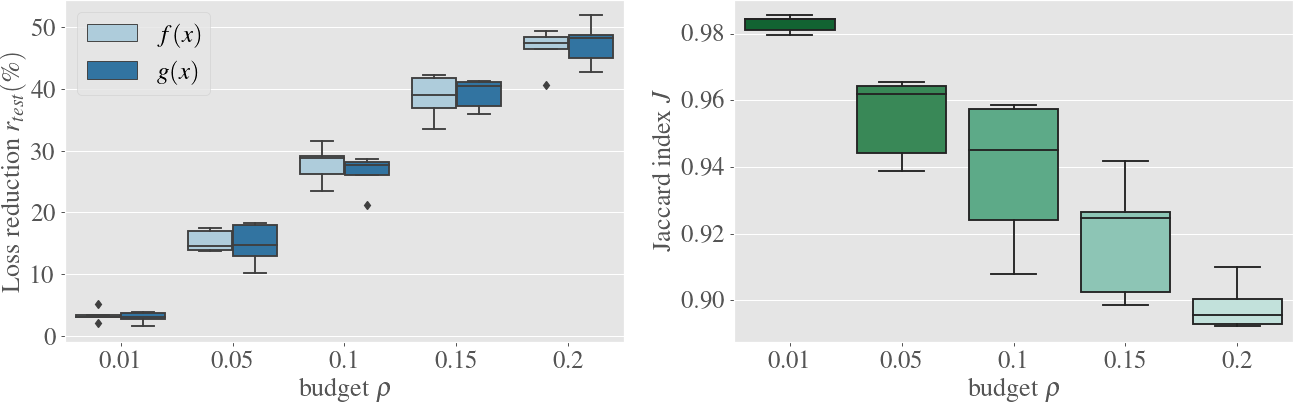

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 5.1), constrained_layout=False, dpi=90)
pal = sns.color_palette('Paired')
sns.boxplot(x=df['rho_user'], y=df['%reduction_test'], hue='label', data=df, ax=ax[0], palette=pal)
ax[0].set_xlabel(r'budget $\rho$')
ax[0].set_ylabel(r'Loss reduction $r_{test}(\%)$')
ax[0].legend(loc='upper left')
pal = sns.color_palette('BuGn_r')
sns.boxplot(x=df_jaccard['rho_user'], y=df_jaccard['jaccard'], data=df_jaccard, ax=ax[1], palette=pal)
ax[1].set_xlabel(r'budget $\rho$')
ax[1].set_ylabel(r'Jaccard index $J$')
plt.tight_layout()
path_fig_fxgx = "drive/My Drive/NIPS2020/results/imdb/fig_fxgx_{clf}_yhat{yhat}_pca{pca}.pdf".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx, bbox_inches='tight', facecolor='w')

In [ ]:
#reverse lookup
INDEX_FROM = 3
word_to_id = tf.keras.datasets.imdb.get_word_index()
word_to_id = {k:(v+INDEX_FROM) for k,v in word_to_id.items()}
word_to_id["<PAD>"] = 0
word_to_id["<START>"] = 1
word_to_id["<UNK>"] = 2
id_to_word = {value:key for key,value in word_to_id.items()}

In [ ]:
rho = 0.15
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 10 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
top_f_idx = top_f_idx[np.argsort(f_test[top_f_idx])]# Added
if clf=='svm':
    crit_test = np.abs(y_test_pred_soft_best.ravel())
    top_crit_idx = np.argpartition(crit_test, top_n)[:top_n]
    top_crit_idx = top_crit_idx[np.argsort(crit_test[top_crit_idx])]# Added
elif clf=='softmax':
    p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
    crit_test = entropy(p_test, axis=1, base=2)
    top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
    top_crit_idx = top_crit_idx[np.argsort(crit_test[top_crit_idx])]# Added
output_text = io.StringIO()
print('eta={:.3f}, theta={:.3f}'.format(eta,theta))

eta=0.149, theta=0.767


In [ ]:
output_text.write("top_n={}, rho_user={}, g(x)={}, addh_hat={}, PCA={}\n".format(top_n,rho,clf, addPredictions, applyPCA))
output_text.write("|f(x)>eta|={}(eta={:.3f}), |g(x)>theta|={}(theta={:.3f})\n".format(np.sum(f_test>eta), eta, np.sum(crit_test<theta) if clf=='svm' else np.sum(crit_test>theta), theta))
output_text.write("\nTop misclassfied instances picked by f(x)\n")
output_text.write("-----------------------------------------\n")
for i in top_f_idx:
  cond = f_test[i]>eta
  if y_test_best[i] != y_test_pred_th_best[i] and cond:
    output_text.write(' '.join([id_to_word[id] for id in X_test_best[i,:] if id!=0])+\
        '\n y={}'.format(y_test_best[i])+', y_pred={}'.format(y_test_pred_th_best[i])+\
        ', g(x)({})={:.3f}'.format('D' if clf=='svm' else 'H', crit_test[i])+\
        ', f(x)={:.3f}'.format(f_test[i])+'\n\n')
print(output_text.getvalue())

top_n=10, rho_user=0.15, g(x)=softmax, addh_hat=True, PCA=True
|f(x)>eta|=309(eta=0.149), |g(x)>theta|=320(theta=0.767)

Top misclassfied instances picked by f(x)
-----------------------------------------
<START> i <UNK> to see the film at the recent <UNK> film festival because it had been <UNK> to the <UNK> film <UNK> <UNK> competition section i was surprised that <UNK> could be so off the mark in judging quality br br the film some reviewers have noted does not have too much of <UNK> but the <UNK> violence is <UNK> imagine killing your enemy <UNK> in front of your young son or <UNK> someone to eat a <UNK> <UNK> to prove <UNK> there are some hints of the <UNK> <UNK> sons in <UNK> godfather that seem to <UNK> here in this chinese hong kong film but the quality of the two are as <UNK> different as <UNK> and cheese br br this film is only recommended for violence <UNK> there is no great cinema here at best it might be considered to be better than the usual run run <UNK> production for pr

In [ ]:
output_text.write("\nTop misclassfied instances picked by g(x)\n")
output_text.write("-----------------------------------------\n")
for i in top_crit_idx:
  cond = crit_test[i]<theta if clf=='svm' else crit_test[i]>theta
  if y_test_best[i] != y_test_pred_th_best[i]:
    output_text.write(' '.join([id_to_word[id] for id in X_test_best[i,:] if id!=0])+\
        '\n y={}'.format(y_test_best[i])+', y_pred={}'.format(y_test_pred_th_best[i])+\
        ', g(x)({})={:.3f}'.format('D' if clf=='svm' else 'H', crit_test[i])+\
        ', f(x)={:.3f}'.format(f_test[i])+'\n\n')
print(output_text.getvalue())

top_n=10, rho_user=0.15, g(x)=softmax, addh_hat=True, PCA=True
|f(x)>eta|=309(eta=0.149), |g(x)>theta|=320(theta=0.767)

Top misclassfied instances picked by f(x)
-----------------------------------------
<START> i <UNK> to see the film at the recent <UNK> film festival because it had been <UNK> to the <UNK> film <UNK> <UNK> competition section i was surprised that <UNK> could be so off the mark in judging quality br br the film some reviewers have noted does not have too much of <UNK> but the <UNK> violence is <UNK> imagine killing your enemy <UNK> in front of your young son or <UNK> someone to eat a <UNK> <UNK> to prove <UNK> there are some hints of the <UNK> <UNK> sons in <UNK> godfather that seem to <UNK> here in this chinese hong kong film but the quality of the two are as <UNK> different as <UNK> and cheese br br this film is only recommended for violence <UNK> there is no great cinema here at best it might be considered to be better than the usual run run <UNK> production for pr

In [ ]:
path_txt = "drive/My Drive/NIPS2020/results/imdb/instances_{clf}_yhat{yhat}_pca{pca}.txt".format(clf=clf, pca=applyPCA, yhat=addPredictions)
txt = open(path_txt, "w") 
txt.writelines(output_text.getvalue()) 
txt.close() #to change file access modes

In [ ]:
report_table_concat = pd.concat(report_table)
table_by_row_index = report_table_concat.groupby(report_table_concat.index)
report_table_mean = table_by_row_index.mean()
report_table_std = table_by_row_index.std()

report_criteria_concat = pd.concat(report_criteria)
table_by_row_index = report_criteria_concat.groupby(report_criteria_concat.index)
report_criteria_mean = table_by_row_index.mean()
report_criteria_std = table_by_row_index.std()

In [ ]:
report_table_mean

,rule,rho_user,error_val,L_val,%reduction_val,eta,p_value,check,budget,error_test,L_test,%reduction_test
0,1.06,0.01,0.00560,0.14192,3.786,0.820517,1.596467e-04,0.01,0.010,0.0049,0.1471,3.218
1,1.20,0.05,0.02472,0.12280,16.776,0.672585,1.438608e-20,0.05,0.054,0.0247,0.1273,16.284
2,0.84,0.10,0.04568,0.10184,31.026,0.448278,2.111505e-39,0.10,0.102,0.0457,0.1063,30.058
3,1.26,0.15,0.06064,0.08688,41.244,0.423398,1.133743e-41,0.15,0.154,0.0634,0.0886,41.738
4,0.12,0.20,0.07376,0.07376,50.104,0.136592,5.266706e-43,0.20,0.200,0.0775,0.0745,50.980


In [ ]:
report_criteria_mean

,rho_user,error_val,L_val,%reduction_val,thresh,budget,error_test,L_test,%reduction_test
0,0.01,0.00488,0.14264,3.306,0.998604,0.012,0.0057,0.1463,3.672
1,0.05,0.02320,0.12432,15.728,0.964553,0.054,0.0242,0.1278,15.878
2,0.10,0.04408,0.10344,29.916,0.885287,0.102,0.0452,0.1068,29.700
3,0.15,0.06088,0.08664,41.324,0.774637,0.152,0.0654,0.0866,43.020
4,0.20,0.07608,0.07144,51.648,0.668580,0.206,0.0825,0.0695,54.300


In [ ]:
report_table_std

,rule,rho_user,error_val,L_val,%reduction_val,eta,p_value,check,budget,error_test,L_test,%reduction_test
0,1.176010,0.0,0.001265,0.007034,0.797076,0.219716,3.569270e-04,0.0,0.000000,0.001817,0.009283,1.190869
1,1.104536,0.0,0.003025,0.007595,2.114800,0.264298,3.187349e-20,0.0,0.005477,0.002564,0.009425,1.828026
2,1.221884,0.0,0.002918,0.007857,2.533146,0.322871,4.721467e-39,0.0,0.008367,0.006535,0.008526,3.697022
3,1.047855,0.0,0.004495,0.010188,4.406856,0.203426,2.432024e-41,0.0,0.008944,0.006628,0.008569,3.804684
4,0.178885,0.0,0.005127,0.009045,4.302619,0.043197,1.177661e-42,0.0,0.010000,0.010186,0.009670,5.632673


In [ ]:
report_criteria_std

,rho_user,error_val,L_val,%reduction_val,thresh,budget,error_test,L_test,%reduction_test
0,0.0,0.000996,0.007357,0.659454,0.000779,0.004472,0.003054,0.007032,1.738094
1,0.0,0.002871,0.006832,1.788413,0.016886,0.005477,0.003347,0.007023,1.419972
2,0.0,0.002834,0.007164,2.081797,0.053454,0.008367,0.005251,0.006496,2.410187
3,0.0,0.004625,0.007785,3.379797,0.081735,0.008367,0.005067,0.005878,1.744506
4,0.0,0.005370,0.008341,4.106479,0.093708,0.008944,0.006225,0.006567,2.760860
